## 1. 设计个小游戏

### 1.1 游戏本身的建模

- 游戏建模在 `2d` 空间
- 8 个向量达标1个 8 边形 表示一个 **小行星**


In [51]:
import math
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from random import randint, uniform

import pygame

from chapters.internal.tools import vectors
from chapters.internal.tools.draw_2d import *


class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0  # 小行星移动的时候, 这个是旋转角度
        self.x = 0
        self.y = 0

    def transformed_wrong(self):
        """
        这里先平移 .  再旋转，就有问题.
        因此 这里的旋转向量是按照 (0,0) 旋转的
        """

        moved_v = [vectors.add((self.x, self.y), v) for v in points]
        rotated = [
            vectors.rotate2d(self.rotation_angle, v)
            for v in moved_v]
        return rotated

    def transformed(self):
        """
        这个方法由 x, y 属性转换 旋转的点 .

        关键是
        1. 先旋转
        2. 再平移
        """
        rotated = [
            vectors.rotate2d(self.rotation_angle, v)
            for v in self.points]
        return [vectors.add((self.x, self.y), v) for v in rotated]


class Ship(PolygonModel):
    """
    飞船是一个三角形
    """

    def __init__(self):
        super().__init__(
            [
                (0.5, 0),
                (-0.25, 0.25),
                (-0.25, -0.25)
            ],
        )


class Asteroid(PolygonModel):
    def __init__(self):
        # 小行星的边是随机的
        sides = randint(5, 9)
        vs = [vectors.to_cartesian(
            (
                # 随机长度是 0.5 -> 1.0
                uniform(0.5, 1.0),
                # 角度绕 360 度, 这样刚好能组成1个多边形
                math.pi * 2 * (i / sides)
            )
        ) for i in range(0, sides)]

        super().__init__(vs)




我们先测试一下画个 小行星 .

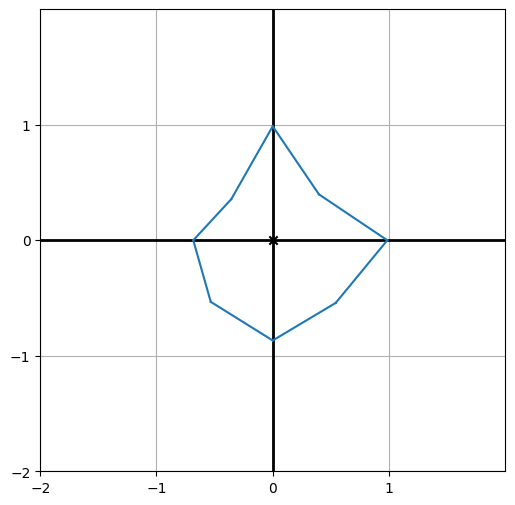

In [52]:
points = Asteroid().points
draw2d(Polygon(*points))

再测试画个小飞船

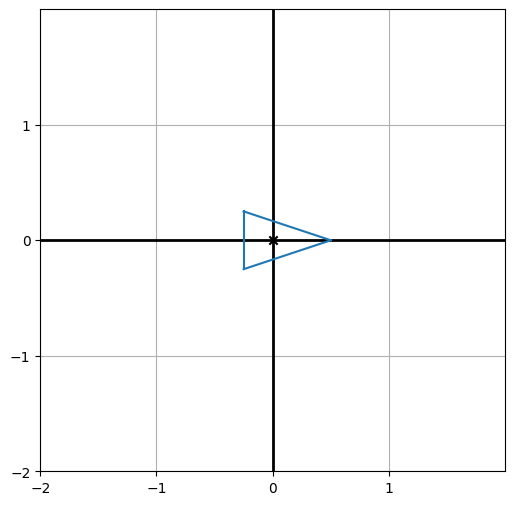

In [53]:
points = Ship().points
draw2d(Polygon(*points))

### 1.1.2 游戏的基本渲染

游戏的初始化状态:

1. 1个 `ship` : 被固定在中心位置
2. 几个 `asteroid` : 随机分布在屏幕上

In [54]:
ship = Ship()

# 1. 创建 一个 小行星列表
asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

# 2. 把他们随机安排在各种位置上
for ast in asteroids:
    ast.x = randint(-9, 9)
    ast.y = randint(-9, 9)

我们打算用  **PyGame** 内置的坐标系来 渲染. 他是一个 400*400 像素的屏幕 .

- PyGame 的坐标系不仅仅更大, 而且被倒置了 .
- 因此. 我们需要先写一个 函数在进行 坐标系的转换.

In [55]:
from chapters.c7.asteroid import main

# 这个是绿色 保护着你
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

width, height = 400, 400


def to_pixels(x, y):
    """
    转换为 PyGames 的坐标系
    """
    return width / 2 + width * x / 20, height / 2 - height * y - 20


v1 = (-9, 9)  # 转换的结果是 (20.0, -3420.0) .怪怪的 .


def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points, 10)


def draw_segment(screen, v1, v2, color=RED):
    pygame.draw.aaline(screen, color, to_pixels(*v1), to_pixels(*v2), 10)



由于 notebook 表示动画的能力有限, 我们放到 专门的代码中

In [56]:
# 打开下面的注释可以看见效果
# main()

### 1.3 实现激光


激光从 `ship` 的头部发出, 到达边界. 假设激光能 一直杀过去的话.

In [57]:
from math import cos, sin


class Ship(PolygonModel):
    def __init__(self):
        super().__init__([(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)])

    def laser_segment(self):
        """
        返回2个向量 代表从 ship 的x,y 出发按照角度一直到边界
        """
        dist = 20. * sqrt(2)  # 长度.
        x, y = self.transformed()[0]
        return (x, y), (x + dist * cos(self.rotation_angle), y + dist * sin(self.rotation_angle))


ship = Ship()
print(ship.laser_segment())

((0.5, 0.0), (28.784271247461902, 0.0))


### 1.4 测试


**exec1** : 我们来测试旋转平移 `ship` 的测试 .

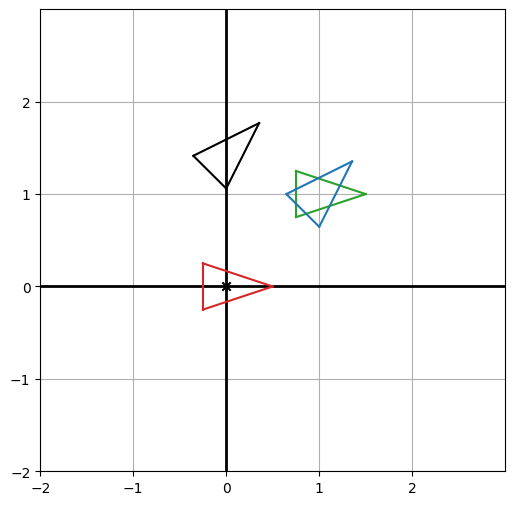

In [58]:
ship = Ship()

ship.x = 1.0
ship.y = 1.0


def ship_2_polygon(s, color=red):
    moved_points = [(p[0] + s.x, p[1] + s.y) for p in s.points]
    return Polygon(*moved_points, color=color)


ship.rotation_angle = math.pi / 4

draw2d(
    Polygon(*ship.points, color=red),
    ship_2_polygon(ship, color=green),
    Polygon(*ship.transformed(), color=blue),
    Polygon(*ship.transformed_wrong(), color=black),
)

- 红色的是原始的
- 绿色的是平移后的
- 蓝色的是正确的
- 黑色是因为先 平移, 再旋转, 所以错了. 旋转是以原点为中心 旋转的. 所以一定要先 **平移**

# 2. 直线的交点计算